# Kuhn Poker - CFR Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed
import time
import sys
import networkx as nx

In [9]:
class KuhnGame:
    def __init__(self):
        '''Constructeur Self'''
        self.nodeMap = {}
        self.expected_game_value = 0
        self.n_cards = 3
        self.nash_equilibrium = dict()
        self.current_player = 0
        self.deck = np.array([0, 1, 2])
        self.n_actions = 2
        self.num_bet = 1
        self.edge_list = []

    #Missing code
    def train(self, n_iterations=50000):
        '''Entraine le modèle en utilisant l'algo CFR'''
        expected_game_value = 0
        seed(42)
        for _ in range(n_iterations):
            shuffle(self.deck) #Pour mélanger le deck
            expected_game_value += self.cfr('', 1, 1)
            for _, v in self.nodeMap.items():
                v.update_strategy()

        expected_game_value /= n_iterations
        display_results(expected_game_value, self.nodeMap)

    def cfr(self, history, pr_1, pr_2):
        '''Algorithme CFR'''
        n = len(history)
        is_player_1 = (n % 2 == 0)
        player_card = self.deck[0] if is_player_1 else self.deck[1]

        if self.is_terminal(history):
            card_player = self.deck[0] if is_player_1 else self.deck[1]
            card_opponent = self.deck[1] if is_player_1 else self.deck[0]
            reward = self.get_reward(history, card_player, card_opponent, is_player_1)
            return reward

        node = self.get_node(player_card, history)
        strategy = node.strategy

        # Counterfactual utility per action
        action_utils = np.zeros(self.n_actions)

        for act in range(self.n_actions):

            next_history = history + node.action_dict[act]
            edge = (history, next_history)
            if edge not in self.edge_list:
                self.edge_list.append(edge)

            if is_player_1:
                action_utils[act] = -1 * self.cfr(next_history, pr_1 * strategy[act], pr_2)
            else:
                action_utils[act] = -1 * self.cfr(next_history, pr_1, pr_2 * strategy[act])

        #Utility of information set
        util = sum(action_utils * strategy)
        regrets = action_utils - util

        if is_player_1:
            node.reach_pr += pr_1
            node.regret_sum += pr_2 * regrets
        else:
            node.reach_pr += pr_2
            node.regret_sum += pr_1 * regrets

        return util

    @staticmethod
    def is_terminal(history):
        '''Valide si le noeud correspond est un noeud final'''
        isTerminal = False
        isTerminal = isTerminal or (history[-2:] == "pp")
        isTerminal = isTerminal or (history[-2:] == "bp")
        isTerminal = isTerminal or (history[-2:] == "bb")
        return isTerminal

    @staticmethod
    def get_reward(history, player_card, opponent_card, is_player_1):
        '''Renvoie la recompense associée à l'historique du jeu'''
        terminal_pass = (history[-1] == 'p')
        double_bet = (history[-2:] == 'bb')
        if terminal_pass:
            if history[-2] == 'pp':
                return 1 if player_card > opponent_card else -1
            else:
                return 1
        elif double_bet:
            return 2 if player_card > opponent_card else -2

    def get_node(self, card, history):
        '''Renvoie le noeud correspondant suivant l'historique de jeu'''
        key = str(card) + " " + history
        if key not in self.nodeMap:
            action_dict = {0: 'p', 1: 'b'}
            info_set = Node(key, action_dict)
            self.nodeMap[key] = info_set
            return info_set
        return self.nodeMap[key]

    def get_unitaryNodeMap(self):
        '''Renvoie graphe unitaire du jeu de poker'''
        G = nx.DiGraph()
        #edge_list = intoGraph(num_bet = num_bet, actions = actions, history = "", edge_list = [], round = 1)
        G.add_edges_from(self.edge_list)
        pos = nx.planar_layout(G)

        print("Edge List : {}".format(self.edge_list))

        # Dessin du graphe
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        return G


In [3]:
def display_results(ev, i_map):
    print('player 1 expected value: {}'.format(ev))
    print('player 2 expected value: {}'.format(-1 * ev))

    print()
    print('player 1 strategies:')
    sorted_items = sorted(i_map.items(), key=lambda x: x[0])
    for _, v in filter(lambda x: len(x[0]) % 2 == 0, sorted_items):
        print(v)
    print()
    print('player 2 strategies:')
    for _, v in filter(lambda x: len(x[0]) % 2 == 1, sorted_items):
        print(v)

In [4]:
class Node:
    def __init__(self, key, action_dict, n_actions = 2):
        self.key = key
        self.n_actions = n_actions

         #Sum of difference between counter factual reward and actual reward
        self.regret_sum = np.zeros(self.n_actions)

        self.strategy_sum = np.zeros(self.n_actions)

        #Possible action
        self.action_dict = action_dict

        #Probability of each possible action in a node
        self.strategy = np.repeat(1/self.n_actions, self.n_actions)

        #Probability of reaching this node on the game tree
        self.reach_pr = 0
        self.reach_pr_sum = 0
        self.num_updates = 0

    def update_strategy(self):
        self.strategy_sum += self.reach_pr * self.strategy
        self.reach_pr_sum += self.reach_pr
        self.strategy = self.get_strategy()
        self.reach_pr = 0
        self.num_updates += 1

    def get_strategy(self):
        regrets = self.regret_sum
        regrets[regrets < 0] = 0
        normalizing_sum = sum(regrets)
        if normalizing_sum > 0:
            return regrets / normalizing_sum
        else:
            return np.repeat(1/self.n_actions, self.n_actions)

    def get_average_strategy(self):

        #strategy = self.strategy_sum
        strategy = self.strategy_sum / self.reach_pr_sum
        # Re normalize
        total = sum(strategy)
        strategy /= total
        return strategy

    def __str__(self):
        strategies = ['{:03.2f}'.format(x) for x in self.get_average_strategy()]
        return '{} {} {}'.format(self.key.ljust(6), strategies, self.num_updates)

player 1 expected value: 0.15112948209530752
player 2 expected value: -0.15112948209530752

player 1 strategies:
0      ['0.99', '0.01'] 998
0 pb   ['1.00', '0.00'] 998
1      ['0.85', '0.15'] 1000
1 pb   ['0.60', '0.40'] 1000
2      ['0.98', '0.02'] 999
2 pb   ['0.00', '1.00'] 999

player 2 strategies:
0 b    ['1.00', '0.00'] 1000
0 p    ['0.69', '0.31'] 1000
1 b    ['0.36', '0.64'] 998
1 p    ['0.13', '0.87'] 998
2 b    ['0.00', '1.00'] 997
2 p    ['0.00', '1.00'] 997
Edge List : [('', 'p'), ('p', 'pp'), ('p', 'pb'), ('pb', 'pbp'), ('pb', 'pbb'), ('', 'b'), ('b', 'bp'), ('b', 'bb')]

Temps de calcul : 0.23228120803833008 secondes
Nombre de noeud : 48


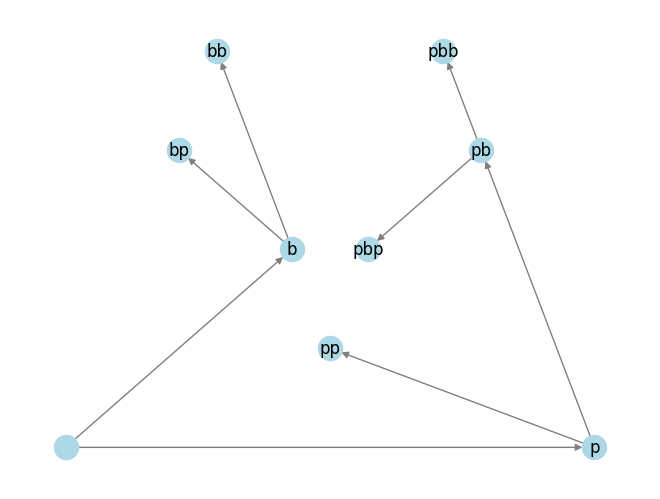

In [10]:
if __name__ == "__main__":
    time1 = time.time()
    trainer = KuhnGame()
    trainer.train(n_iterations=1000)
    trainer.get_unitaryNodeMap()

    print()
    print("Temps de calcul : {} secondes".format(abs(time1 - time.time())))
    print("Nombre de noeud : {}".format(sys.getsizeof(trainer))) #48 noeuds

In [ ]:
if __name__ == "__main__":
    time1 = time.time()
    trainer = KuhnGame()
    trainer.train(n_iterations=1)
    trainer.get_unitaryNodeMap()

    print()
    print("Temps de calcul : {} secondes".format(abs(time1 - time.time())))
    print("Nombre de noeud : {}".format(sys.getsizeof(trainer))) #48 noeuds